This notebook will go through the pipeline for normalizing an fMRI dataset into the MNI template space.

In [1]:
import os,shutil
import sklearn.metrics

try:
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/myconnectome/sub00001'

print 'Using data from',datadir

%matplotlib inline

from nipype.interfaces import fsl
import nibabel
import numpy
import nilearn.plotting
import matplotlib.pyplot as plt
from nipype.interfaces import ants
from nipype.caching import Memory
mem = Memory(base_dir='.')
results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

Using data from /home/vagrant/data


In [2]:
subject='ses014'  
# note - we have to use the anatomy from a different session'
anat_subject='ses018'
bolddir=os.path.join(datadir,'ds031/sub00001',subject,
        'functional')

meanbold_unwarped_file=os.path.join(results_dir, "meanbold_unwarped.nii.gz")
meanbold=os.path.join(results_dir, "meanbold.nii.gz")
fmapmag=os.path.join(results_dir, "fmapmag.nii.gz")
fmapmagbrain=os.path.join(results_dir, "fmapmagbrain.nii.gz")
fmap=os.path.join(results_dir, "fieldmap.nii.gz")
bold_file=os.path.join(bolddir,
    'sub00001_ses014_task002_run001_bold_mcf_brain_unwarped.nii.gz')
anatomydir=os.path.join(datadir,'ds031/sub00001',anat_subject,
        'anatomy')
t1file=os.path.join(anatomydir,'sub00001_ses018_T1w_001.nii.gz')


Bias field correction of the T1

In [3]:
bias_field_correcton = mem.cache(ants.N4BiasFieldCorrection)
bias_field_correcton_results = bias_field_correcton(input_image = t1file, 
                                                    dimension = 3,
                                                    save_bias = True)
bias_field_correcton_results.outputs

INFO:workflow:Executing node 806a4ed0b080946a11dfa6ece7d7bcce in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/806a4ed0b080946a11dfa6ece7d7bcce
INFO:workflow:Collecting precomputed outputs



bias_image = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/806a4ed0b080946a11dfa6ece7d7bcce/sub00001_ses018_T1w_001_bias.nii.gz
output_image = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/806a4ed0b080946a11dfa6ece7d7bcce/sub00001_ses018_T1w_001_corrected.nii.gz

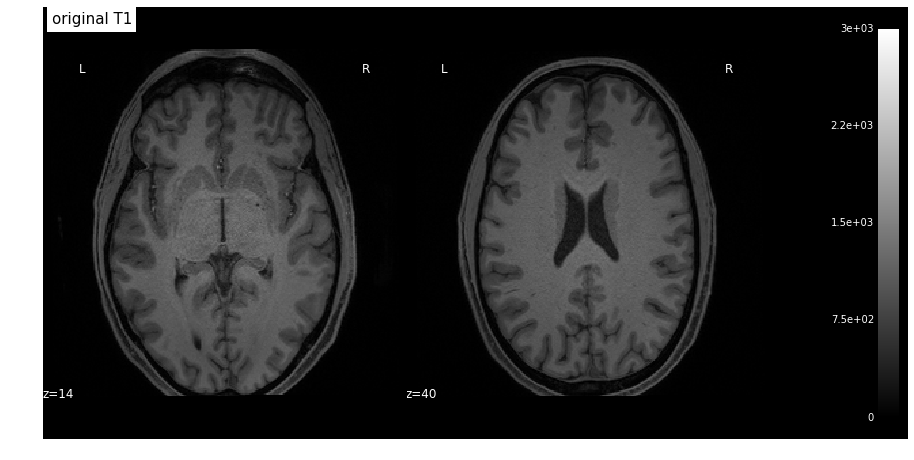

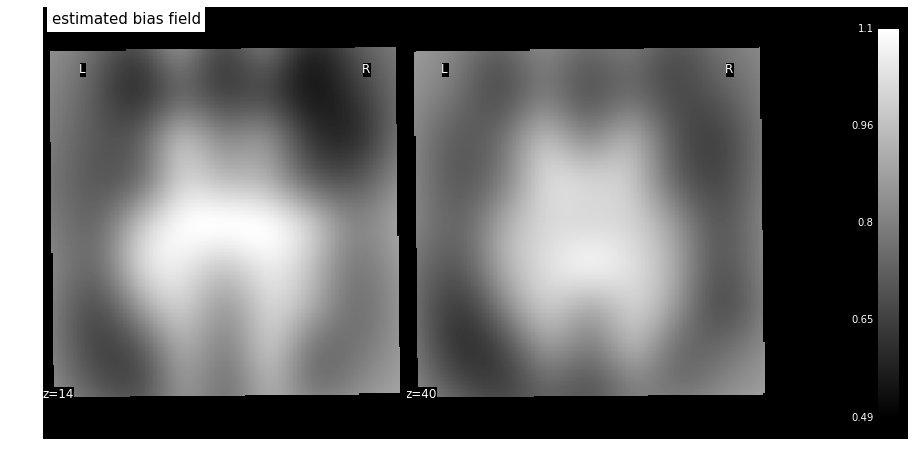

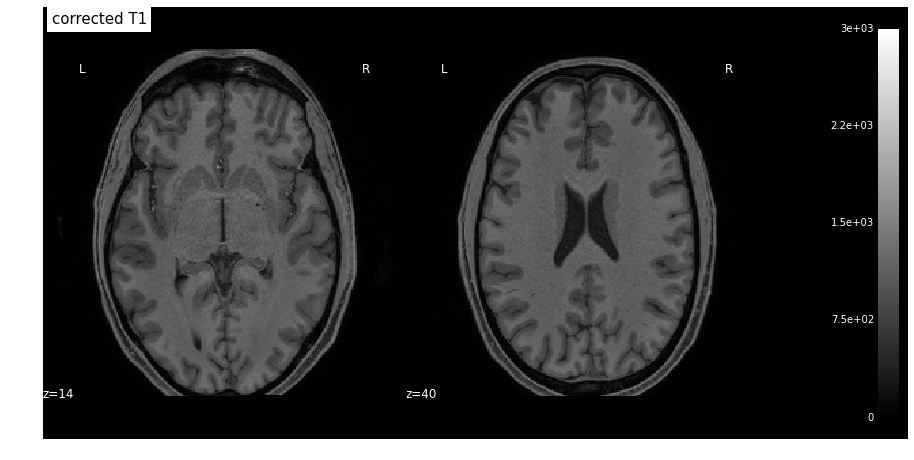

In [4]:
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(t1file, colorbar=True, vmax=3000, display_mode='z', cut_coords=(14, 40), 
                           title="original T1", figure=fig)
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(bias_field_correcton_results.outputs.bias_image, display_mode='z', 
                          cut_coords=(14, 40), colorbar=True, title="estimated bias field", figure=fig)
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(bias_field_correcton_results.outputs.output_image, colorbar=True, 
                           vmax=3000, display_mode='z', cut_coords=(14, 40), title="corrected T1", figure=fig)

Perform brain extraction using BET

In [5]:
bet = mem.cache(fsl.BET)
bet_results = bet(in_file=bias_field_correcton_results.outputs.output_image,
                  mask=True,
                  frac=0.3)
bet_results.outputs

INFO:workflow:Executing node c8f784997e8bc71921a1e6a92043791c in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/c8f784997e8bc71921a1e6a92043791c
INFO:workflow:Collecting precomputed outputs



inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/c8f784997e8bc71921a1e6a92043791c/sub00001_ses018_T1w_001_corrected_brain_mask.nii.gz
meshfile = <undefined>
out_file = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/c8f784997e8bc71921a1e6a92043791c/sub00001_ses018_T1w_001_corrected_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>

Visualize brain mask overlaid on anatomy

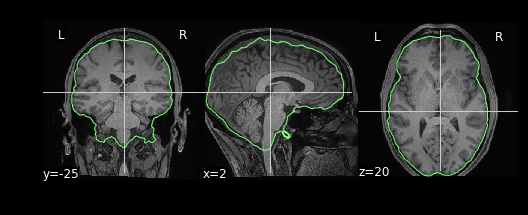

In [6]:
mask_display=nilearn.plotting.plot_epi(t1file,cmap='gray')
mask_display.add_contours(bet_results.outputs.mask_file, levels=[.5]) 

In [7]:
epi_reg = mem.cache(fsl.EpiReg)
epi_reg_results = epi_reg(epi=meanbold,
                          t1_head=bias_field_correcton_results.outputs.output_image,
                          t1_brain=bet_results.outputs.out_file,
                          fmap=fmap,
                          fmapmag=fmapmag,
                          fmapmagbrain=fmapmagbrain,
                          echospacing=2.6/10000.0,
                          pedir='y',
                          out_base="epi2struct")
epi_reg_results.outputs

INFO:workflow:Executing node 2bf7c4c475822f80a6e12984eb73b3d6 in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/2bf7c4c475822f80a6e12984eb73b3d6
INFO:workflow:Collecting precomputed outputs



epi2str_inv = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/2bf7c4c475822f80a6e12984eb73b3d6/epi2struct_inv.mat
epi2str_mat = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/2bf7c4c475822f80a6e12984eb73b3d6/epi2struct.mat
fmap2epi_mat = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/2bf7c4c475822f80a6e12984eb73b3d6/epi2struct_fieldmaprads2epi.mat
fmap2str_mat = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/2bf7c4c475822f80a6e12984eb73b3d6/epi2struct_fieldmap2str.mat
fmap_epi = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/2bf7c4c475822f80a6e12984eb73b3d6/epi2struct_fieldmaprads2epi.nii.gz
fmap_str = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/2bf7c4c475822f80a6e12984eb73b3d6/epi2

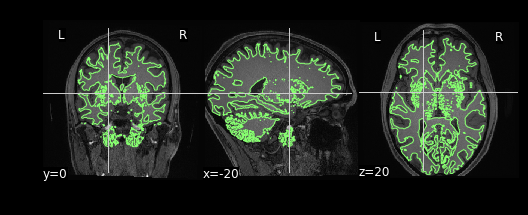

In [8]:
mask_display=nilearn.plotting.plot_epi(t1file,cmap='gray', cut_coords=(-20,0,20))
mask_display.add_contours(epi_reg_results.outputs.wmseg, levels=[.5]) 

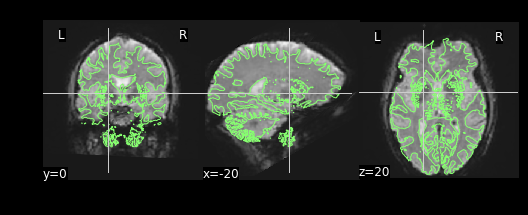

In [9]:
mask_display=nilearn.plotting.plot_epi(epi_reg_results.outputs.out_file,cmap='gray', cut_coords=(-20,0,20))
mask_display.add_contours(epi_reg_results.outputs.wmseg, levels=[.5]) 

Normalization with ANTs

In [17]:
from nipype.interfaces import ants
ants = mem.cache(ants.Registration)
ants_results = ants(fixed_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                    moving_image = bias_field_correcton_results.outputs.output_image,
                    transforms = ['Translation', 'Rigid', 'Affine', 'SyN'],
                    transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)],
                    #number_of_iterations = ([[10000, 111110, 11110]]*3 +
                    #                [[100, 50, 30]]),
                    number_of_iterations = ([[10, 10, 10]]*3 +
                                    [[1, 5, 3]]),
                    dimension = 3,
                    write_composite_transform = False,
                    metric = ['Mattes'] * 3 + [['Mattes', 'CC']],
                    metric_weight = [1] * 3 + [[0.5, 0.5]],
                    radius_or_number_of_bins = [32] * 3 + [[32, 4]],
                    sampling_strategy = ['Regular'] * 3 + [[None, None]],
                    sampling_percentage = [0.3] * 3 + [[None, None]],
                    convergence_threshold = [1.e-8] * 3 + [-0.01],
                    convergence_window_size = [20] * 3 + [5],
                    smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]],
                    sigma_units = ['vox'] * 4,
                    shrink_factors = [[6, 4, 2]] + [[3, 2, 1]]*2 + [[4, 2, 1]],
                    use_estimate_learning_rate_once = [True] * 4,
                    use_histogram_matching = [False] * 3 + [True],
                    initial_moving_transform_com = True)
ants_results.outputs

Traceback (most recent call last):
  File "/home/vagrant/miniconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/vagrant/miniconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "/home/vagrant/miniconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 267, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/vagrant/miniconda/lib/python2.7/inspect.py", line 1044, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/vagrant/miniconda/lib/python2.7/inspect.py", line 1004, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/home/vagrant/miniconda/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
 

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

In [13]:
!rm -rf /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-registration-Registration/

Perform bias field correction on T1-weighted image using FSL's FAST.

In [5]:
fast = mem.cache(fsl.FAST)
fast_results = fast(in_files = bet_results.outputs.out_file,
                    output_biascorrected=True)
fast_results.outputs

INFO:workflow:Executing node 4ad24691c4dd7d5c91bdb0002b8e4a5f in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/4ad24691c4dd7d5c91bdb0002b8e4a5f
INFO:workflow:Running: fast -B -S 1 /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/4ad24691c4dd7d5c91bdb0002b8e4a5f/sub00001_ses018_T1w_001_brain.nii.gz



bias_field = <undefined>
mixeltype = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/4ad24691c4dd7d5c91bdb0002b8e4a5f/sub00001_ses018_T1w_001_brain_mixeltype.nii.gz
partial_volume_files = ['/home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/4ad24691c4dd7d5c91bdb0002b8e4a5f/sub00001_ses018_T1w_001_brain_pve_0.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/4ad24691c4dd7d5c91bdb0002b8e4a5f/sub00001_ses018_T1w_001_brain_pve_1.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/4ad24691c4dd7d5c91bdb0002b8e4a5f/sub00001_ses018_T1w_001_brain_pve_2.nii.gz']
partial_volume_map = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/4ad24691c4dd7d5c91bdb0002b8e4a5f/sub00001_ses018_T1w_001_brain_pveseg.nii.gz
probabil

Visualize white matter mask

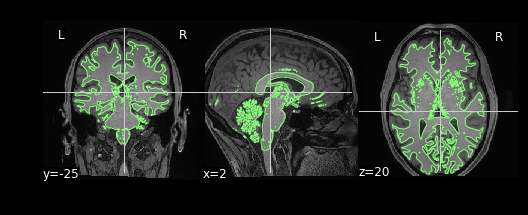

In [6]:
mask_display=nilearn.plotting.plot_epi(t1file,cmap='gray')
mask_display.add_contours(fast_results.outputs.partial_volume_files[2], levels=[.5]) 

Register mean unwarped functional to anatomy using corratio

In [7]:
flirt = mem.cache(fsl.FLIRT)
flirt_results = flirt(in_file = meanbold_unwarped_file,
                      reference = fast_results.outputs.restored_image,
                      wm_seg = fast_results.outputs.partial_volume_files[2])
flirt_results.outputs

INFO:workflow:Executing node 9972bf5e9a5650166e1e75a805d68c61 in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/9972bf5e9a5650166e1e75a805d68c61
INFO:workflow:Running: flirt -in /home/vagrant/fmri-analysis-vm/analysis/results/meanbold_unwarped.nii.gz -ref /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/4ad24691c4dd7d5c91bdb0002b8e4a5f/sub00001_ses018_T1w_001_brain_restore.nii.gz -out meanbold_unwarped_flirt.nii.gz -omat meanbold_unwarped_flirt.mat -wmseg /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/4ad24691c4dd7d5c91bdb0002b8e4a5f/sub00001_ses018_T1w_001_brain_pve_2.nii.gz



out_file = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/9972bf5e9a5650166e1e75a805d68c61/meanbold_unwarped_flirt.nii.gz
out_log = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/9972bf5e9a5650166e1e75a805d68c61/meanbold_unwarped_flirt.log
out_matrix_file = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/9972bf5e9a5650166e1e75a805d68c61/meanbold_unwarped_flirt.mat

Register mean unwarped functional to anatomy using BBR (using the matrix from the corratio registration as a starting point)

In [8]:
flirt_results_bbr = flirt(in_file = meanbold_unwarped_file,
                          reference = fast_results.outputs.restored_image,
                          wm_seg = fast_results.outputs.partial_volume_files[2],
                          cost_func='bbr',verbose=6,dof=7,
                          schedule = os.path.join(os.getenv('FSLDIR'),
                                                'etc/flirtsch/bbr.sch'))
flirt_results_bbr.outputs

INFO:workflow:Executing node 3518662f92147480c04dfc01edd20a52 in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/3518662f92147480c04dfc01edd20a52
INFO:workflow:Running: flirt -in /home/vagrant/fmri-analysis-vm/analysis/results/meanbold_unwarped.nii.gz -ref /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/4ad24691c4dd7d5c91bdb0002b8e4a5f/sub00001_ses018_T1w_001_brain_restore.nii.gz -out meanbold_unwarped_flirt.nii.gz -omat meanbold_unwarped_flirt.mat -searchcost bbr -dof 7 -schedule /usr/share/fsl/5.0/etc/flirtsch/bbr.sch -verbose 6 -wmseg /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FAST/4ad24691c4dd7d5c91bdb0002b8e4a5f/sub00001_ses018_T1w_001_brain_pve_2.nii.gz
INFO:interface:stdout 2015-08-12T05:57:31.503726:Refvol intensity clamped between 0 and 1051.81
INFO:interface:stdout 2015-08-12T05:57:31.534265:Testvol sampling


out_file = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/3518662f92147480c04dfc01edd20a52/meanbold_unwarped_flirt.nii.gz
out_log = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/3518662f92147480c04dfc01edd20a52/meanbold_unwarped_flirt.log
out_matrix_file = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/3518662f92147480c04dfc01edd20a52/meanbold_unwarped_flirt.mat

Which is better?

In [9]:
from nilearn.masking import apply_mask

def calc_MI(x, y, bins=10):
    # compute mutual information between two variables
    c_xy = numpy.histogram2d(x, y, bins)[0]
    mi = sklearn.metrics.mutual_info_score(None, None, contingency=c_xy)
    return mi

bcfdata=apply_mask(fast_results.outputs.restored_image, 
                   bet_results.outputs.mask_file)

crdata=apply_mask(flirt_results.outputs.out_file, 
                  bet_results.outputs.mask_file)
bbrdata=apply_mask(flirt_results_bbr.outputs.out_file, 
                   bet_results.outputs.mask_file)

print 'Mutual information with target:'
mi_bbr=calc_MI(bcfdata,bbrdata)
print 'BBR:',mi_bbr
mi_cr=calc_MI(bcfdata,crdata)
print 'corratio:',mi_cr

Mutual information with target:
BBR: 0.166741686127
corratio: 0.145252487495


In [ ]:
epi_reg = mem.cach(fsl.EpiReg)
flirt_results_bbr = epi_reg(epi = meanbold_unwarped_file,
                          reference = fast_results.outputs.restored_image,
                          wm_seg = fast_results.outputs.partial_volume_files[2],
                          cost_func='bbr',verbose=6,dof=7,
                          schedule = os.path.join(os.getenv('FSLDIR'),
                                                'etc/flirtsch/bbr.sch'))
flirt_results_bbr.outputs

Now let's register our functional data to the MNI template, and generate a composite transform.  Start out using FLIRT.

In [10]:
mnimat_flirt=bfcfile.replace('.nii.gz','_reg2mni.mat')
if not os.path.exists(mnimat_flirt):
    flt = fsl.FLIRT(cost_func='normcorr',dof=12)
    flt.inputs.in_file = bfcfile
    flt.inputs.reference = os.path.join(os.getenv('FSLDIR'),
                            'data/standard/MNI152_T1_2mm_brain.nii.gz')
    flt.inputs.out_file = bfcfile.replace('.nii.gz','_reg2mni.nii.gz')
    flt.inputs.out_matrix_file = mnimat_flirt
    flt.run()
else:
    print 'using existing FLIRT MNI registration'

NameError: name 'bfcfile' is not defined

In [ ]:
flirt_resul

In [ ]:
if 0: #not os.path.exists(bfcfile.replace('.nii.gz','_nlreg2mni_warped.nii.gz')):

    flt = fsl.FNIRT()
    flt.inputs.in_file = bfcfile
    flt.inputs.affine_file=mnimat_flirt
    flt.inputs.ref_file = os.path.join(os.getenv('FSLDIR'),
                            'data/standard/MNI152_T1_2mm_brain.nii.gz')
    flt.inputs.warped_file = bfcfile.replace('.nii.gz','_nlreg2mni_warped.nii.gz')
    flt.inputs.field_file = bfcfile.replace('.nii.gz','_nlreg2mni_field')
    flt.run()
else:
    print 'using existing FLIRT MNI registration'

Use ANTS to register to MNI152 T1

In [ ]:
mnimaskdata=nibabel.load(os.path.join(os.getenv('FSLDIR'),
            'data/standard/MNI152_T1_2mm_brain_mask.nii.gz')).get_data()
mnimaskvox=numpy.where(mnimaskdata)
mnidata=nibabel.load(os.path.join(os.getenv('FSLDIR'),
            'data/standard/MNI152_T1_2mm_brain.nii.gz')).get_data()[mnimaskvox]

flirtimg=nibabel.load(bfcfile.replace('.nii.gz',
            '_reg2mni.nii.gz'))
flirtdata=flirtimg.get_data()[mnimaskvox]
fnirtimg=nibabel.load(bfcfile.replace('.nii.gz',
            '_nlreg2mni_warped.nii.gz'))
fnirtdata=fnirtimg.get_data()[mnimaskvox]
print 'Mutual information with target:'
mi_flirt=calc_MI(mnidata,flirtdata)
print 'FLIRT:',mi_flirt
mi_fnirt=calc_MI(mnidata,fnirtdata)
print 'FNIRT:',mi_fnirt

Plot outlines onto template

In [ ]:
mniimg=nibabel.load(os.path.join(os.getenv('FSLDIR'),
                            'data/standard/MNI152_T1_2mm_brain.nii.gz'))

mask_display=nilearn.plotting.plot_epi(mniimg,cmap='gray')
mask_display.add_edges(flirtimg) 

In [ ]:
mask_display=nilearn.plotting.plot_epi(mniimg,cmap='gray')
mask_display.add_edges(fnirtimg) 

Apply FNIRT warp to EPI data

In [ ]:
unwarped_reg2mni=bold_file.replace('.nii.gz','_nlreg2mni.nii.gz')
if 0: #not os.path.exists(unwarped_reg2mni):
    aw = fsl.ApplyWarp()
    aw.inputs.in_file = bold_file
    aw.inputs.ref_file = os.path.join(os.getenv('FSLDIR'),
                                'data/standard/MNI152_T1_2mm_brain.nii.gz')
    aw.inputs.field_file = bfcfile.replace('.nii.gz','_nlreg2mni_field.nii.gz')
    aw.inputs.postmat=mnimat_flirt
    aw.inputs.out_file=unwarped_reg2mni
    aw.run()


Warp the gray matter mask back into the functional space, so we can use it for the analysis

In [ ]:
# first invert the warp from the bbrmat
invt = fsl.ConvertXFM()
invt.inputs.in_file = bbrmat
invt.inputs.invert_xfm = True
invt.inputs.out_file = bbrmat.replace('.mat','_inv.mat')
if not os.path.exists(invt.inputs.out_file):
    invt.run()
    
applyxfm=fsl.ApplyXfm()
applyxfm.inputs.in_file = os.path.join(anatomydir,'sub00001_ses018_T1w_001_brain_FAST_pve_1.nii.gz')
applyxfm.inputs.in_matrix_file = invt.inputs.out_file
applyxfm.inputs.out_file = os.path.join(bolddir,'gray_matter_mask.nii.gz')
applyxfm.inputs.reference = meanbold_unwarped_file
applyxfm.inputs.apply_xfm = True
if not os.path.exists(applyxfm.inputs.out_file):
    result = applyxfm.run()

gmthresh=0.25
if not os.path.exists(os.path.join(bolddir,'gray_matter_mask_bin.nii.gz')):
    gm=nibabel.load(os.path.join(bolddir,'gray_matter_mask.nii.gz'))
    gmdata=gm.get_data()
    gmdata[gmdata<gmthresh]=0
    gmdata[gmdata>0]=1
    gmbin=nibabel.Nifti1Image(gmdata,gm.get_affine())
    gmbin.to_filename(os.path.join(bolddir,'gray_matter_mask_bin.nii.gz'))